In [1]:
import re
from dataclasses import dataclass
import matplotlib.pyplot as plt
import json
from collections import defaultdict

@dataclass
class ModelConfig:
    n_iter: int
    size: float
    data: str
    tokenizer: str
    n_tokens: int
    global_bs: int
    context: int
    schedule: str
    lr: float
    warmup: int

def parse_model_path(path):
    # Extract the filename part (after the last /)
    parts = path.split('/')
    
    # Find the part containing all the model config (long string with parameters)
    # /leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-DCLM_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14070018/hf/iter_0114000
    config_string = None
    for part in parts:
        if "model-" in part or "data-" in part:
            config_string = part
            break
    assert not config_string is None, path
    
    iter_match = re.search(r'iter_(\d+)', path)
    n_iter = int(iter_match.group(1)) if iter_match else None
    
    size_match = re.search(r'model-(\d+\.?\d*)b', config_string)
    size = float(size_match.group(1)) if size_match else None
    
    data_match = re.search(r'data-([^_]+)', config_string)
    data = data_match.group(1) if data_match else None
    
    tokenizer_match = re.search(r'tokenizer-([^_]+)', config_string)
    tokenizer = tokenizer_match.group(1) if tokenizer_match else None
    
    tokens_match = re.search(r'samples-(\d+)B', config_string)
    n_tokens = int(tokens_match.group(1)) if tokens_match else None
    
    bs_match = re.search(r'global_bs-(\d+)', config_string)
    global_bs = int(bs_match.group(1)) if bs_match else None
    
    context_match = re.search(r'context-(\d+)', config_string)
    context = int(context_match.group(1)) if context_match else None
    
    schedule_match = re.search(r'schedule-(\w+)', config_string)
    schedule = schedule_match.group(1) if schedule_match else None
    
    lr_match = re.search(r'lr-(\d+e-\d+)', config_string)
    lr = float(lr_match.group(1)) if lr_match else None
    
    warmup_match = re.search(r'warmup-(\d+)', config_string)
    warmup = int(warmup_match.group(1)) if warmup_match else None
    
    return ModelConfig(
        n_iter=n_iter,
        size=size,
        data=data,
        tokenizer=tokenizer,
        n_tokens=n_tokens,
        global_bs=global_bs,
        context=context,
        schedule=schedule,
        lr=lr,
        warmup=warmup
    )

# Example usage
path = "/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-DCLM_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14070018/hf/iter_0114000"
config = parse_model_path(path)
print(config)

ModelConfig(n_iter=114000, size=1.7, data='DCLM', tokenizer='GPT-NeoX', n_tokens=1000, global_bs=1008, context=4096, schedule='WSD_lr', lr=0.004, warmup=25000)


In [266]:
from pathlib import Path
import pandas as pd


In [ ]:
cols = [
    "mmlu/acc",
    "mmlu_pro/exact_match,custom-extract",
    "copa/acc",
    "lambada_openai/acc",
    "openbookqa/acc",
    "winogrande/acc",
    "arc_challenge/acc",
    "arc_easy/acc_norm",
    "boolq/acc",
    "commonsense_qa/acc",
    "hellaswag/acc_norm",
    "piqa/acc_norm",    
    "social_iqa/acc",
]


In [325]:
model_results = defaultdict(list)
rows = []
json_files = list(Path("/Users/salinasd/Documents/code/Megatron-LM-Open-Sci/data/json_files_selected/").rglob("*results*.json"))

for json_file in json_files:
    #if "14798246" not in str(json_file):
    #    continue
    with open(json_file, "r") as f:
        json_dict = json.load(f)
        model_path = json_dict["model_name"]
        # allow to filter smol/qwen evals
        for col in cols:
            benchmark_name, metric = col.split("/")
            if benchmark_name in json_dict["results"]:                
                metric_col = f"{metric},none" if benchmark_name != "mmlu_pro" else metric                
                hp = parse_model_path(model_path).__dict__
                
                model_name = Path(model_path).parent.parent.name
                row = {
                    "model_name": model_name,
                    "model_path": model_path,
                    #"n_iter": hp["n_iter"],
                    "benchmark": benchmark_name,
                    "value": json_dict["results"][benchmark_name][metric_col],
                }
                row.update(hp)
                if "leonardo_work" in model_path:                
                    rows.append(row)
                else:
                    rows_baselines.append(row)
rows[-1]

{'model_name': 'open-sci-ref_model-0.13b_data-DCLM_tokenizer-GPT-NeoX-2_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-6e-3_warmup-25000_machine-LEONARDO_14333754',
 'model_path': '/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-0.13b_data-DCLM_tokenizer-GPT-NeoX-2_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-6e-3_warmup-25000_machine-LEONARDO_14333754/hf/iter_0012000',
 'benchmark': 'mmlu',
 'value': 0.259222333000997,
 'n_iter': 12000,
 'size': 0.13,
 'data': 'DCLM',
 'tokenizer': 'GPT-NeoX-2',
 'n_tokens': 300,
 'global_bs': 1008,
 'context': 4096,
 'schedule': 'WSD_lr',
 'lr': 0.006,
 'warmup': 25000}

In [326]:
df = pd.DataFrame(rows)
print(df.columns)
df.head()
#df

Index(['model_name', 'model_path', 'benchmark', 'value', 'n_iter', 'size',
       'data', 'tokenizer', 'n_tokens', 'global_bs', 'context', 'schedule',
       'lr', 'warmup'],
      dtype='object')


,model_name,model_path,benchmark,value,n_iter,size,data,tokenizer,n_tokens,global_bs,context,schedule,lr,warmup
0,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,/leonardo_work/EUHPC_E03_068/tcarsten/converte...,copa,0.690000,11921,1.7,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500
1,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,/leonardo_work/EUHPC_E03_068/tcarsten/converte...,lambada_openai,0.469823,11921,1.7,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500
2,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,/leonardo_work/EUHPC_E03_068/tcarsten/converte...,openbookqa,0.232000,11921,1.7,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500
3,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,/leonardo_work/EUHPC_E03_068/tcarsten/converte...,winogrande,0.541436,11921,1.7,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500
4,open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-...,/leonardo_work/EUHPC_E03_068/tcarsten/converte...,social_iqa,0.416070,11921,1.7,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500


In [273]:
model_results = defaultdict(list)
rows_baselines = []
json_files = list(Path("/Users/salinasd/Documents/code/Megatron-LM-Open-Sci/data/json_files/").rglob("*results*.json"))
for json_file in json_files:
    #if "14798246" not in str(json_file):
    #    continue
    with open(json_file, "r") as f:
        json_dict = json.load(f)
        model_path = json_dict["model_name"]
        # allow to filter smol/qwen evals
        for col in cols:
            benchmark_name, metric = col.split("/")
            if benchmark_name in json_dict["results"]:                
                metric_col = f"{metric},none" if benchmark_name != "mmlu_pro" else metric                                
                model_name = Path(model_path).parent.parent.name
                row = {
                    "model_name": model_name,
                    "model_path": model_path,
                    #"n_iter": hp["n_iter"],
                    "benchmark": benchmark_name,
                    "value": json_dict["results"][benchmark_name][metric_col],
                }
                if "leonardo_work" not in model_path:                
                    rows_baselines.append(row)
rows_baselines[-1]

{'model_name': '',
 'model_path': 'HuggingFaceFW/ablation-model-c4',
 'benchmark': 'social_iqa',
 'value': 0.4211873080859775}

In [274]:
df_baselines = pd.DataFrame(rows_baselines)
df_baselines

,model_name,model_path,benchmark,value
0,,HuggingFaceFW/ablation-model-fineweb-edu,copa,0.780000
1,,HuggingFaceFW/ablation-model-fineweb-edu,lambada_openai,0.501844
2,,HuggingFaceFW/ablation-model-fineweb-edu,openbookqa,0.310000
3,,HuggingFaceFW/ablation-model-fineweb-edu,winogrande,0.579321
4,,HuggingFaceFW/ablation-model-fineweb-edu,social_iqa,0.411464
...,...,...,...,...
144,,HuggingFaceFW/ablation-model-c4,copa,0.720000
145,,HuggingFaceFW/ablation-model-c4,lambada_openai,0.525325
146,,HuggingFaceFW/ablation-model-c4,openbookqa,0.226000
147,,HuggingFaceFW/ablation-model-c4,winogrande,0.568272


In [376]:
benchmarks = ['copa', 'lambada_openai', 'openbookqa', 'winogrande', 'social_iqa',
       'mmlu', 'mmlu_pro', 'arc_challenge', 'arc_easy', 'boolq',
       'commonsense_qa', 'hellaswag', 'piqa']

In [377]:
print(f"Number of models: {len(df.model_name.unique())}, numbers of checkpoints: {len(df.model_path.unique())}")

Number of models: 35, numbers of checkpoints: 990


## Analysis count & missing

In [378]:
# name of models to be evaluated
with open("models.txt", "r") as f:
    models_file = f.readlines()
    models_file = [x.strip() for x in models_file]
    

In [379]:
#pd.DataFrame([parse_model_path(x) for x in models_file])

In [380]:
# name of models + iterations to be evaluated
with open("models_with_iter.txt", "r") as f:
    models_iter_file = f.readlines()
    models_iter_file = [x.strip() for x in models_iter_file]
    

In [381]:
# number of model/iteration which are missing one evaluation
df_missing = ~df.pivot_table(index="model_path", columns="benchmark", aggfunc="count")["value"].isna()
models_iteration_missing = []
for model in models_iter_file:
    if model not in df_missing.index:
        models_iteration_missing.append(model)
len(models_iteration_missing)

164

In [382]:
# number of models which do not have ANY evaluation
df_missing = ~df.pivot_table(index="model_name", columns="benchmark", aggfunc="count")["value"].isna()
models_missing = []
for model in models_file:
    if str(Path(model).name) not in df_missing.index:
        models_missing.append(Path(model).name)
print("\n".join(models_missing))

open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-NeoX_samples-50B_global_bs-2048_context-2048_schedule-WSD_lr-4e-3_warmup-1000_untie-embbed_no-softmax-fusion_machine-LEONARDO_11445380
open-sci-ref_model-1.7b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_13977373
open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-NeoX_samples-50B_global_bs-2048_context-2048_schedule-WSD_lr-4e-3_warmup-1000_disable-bias_no-softmax-fusion_machine-LEONARDO_11445667
open-sci-ref_model-1.7b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_13715533
open-sci-ref_model-0.13b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14467405
open-sci-ref_model-1.7b_data-Nemotron-cc-2024-HQ-real-synth-mix_tokenizer-GPT-NeoX_s

In [383]:
# 902 model/checkpoints contains all evaluations if excl mmlu_pro
df_count = df.pivot_table(index="model_path", columns="benchmark", aggfunc="count")["value"]
df_count[df_count>1] = 1
df_count.sum(axis=0)

benchmark
arc_challenge     902.0
arc_easy          902.0
boolq             902.0
commonsense_qa    902.0
copa              990.0
hellaswag         902.0
lambada_openai    990.0
mmlu              990.0
mmlu_pro          469.0
openbookqa        990.0
piqa              902.0
social_iqa        990.0
winogrande        990.0
dtype: float64

In [384]:
# gets list of benchmark/models that are missing
#missing = defaultdict([
#    (model, task)
#])
model_benchmark_count = {}
for model_path in models_iter_file:
    for task in benchmarks:
        model_benchmark_count[(model_path, task)] = 0


for model_path, benchmark in df.loc[:, ["model_path", "benchmark"]].values:
    model_benchmark_count[(model_path, benchmark)] += 1

missing = [k for k, v in model_benchmark_count.items() if v == 0]
len(missing)

3181

In [385]:
len(set([Path(k).parent.parent.name for (k, b), v in model_benchmark_count.items() if v == 0]))

30

## Scores analysis

In [386]:
df.benchmark.unique()
bench_sel = ['mmlu', 'copa', 'lambada_openai', 'openbookqa', 'winogrande', 'arc_challenge', 'boolq', 'commonsense_qa', 'hellaswag', 'piqa']

In [387]:
df_scores = df.pivot_table(index="model_path", columns="benchmark", aggfunc="max")["value"].loc[:, bench_sel]

In [388]:
df_scores.dropna().mean(axis=1).sort_values(ascending=False)

model_path
/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-DCLM_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14070018/hf/iter_0240000                0.540071
/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-DCLM_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14070018/hf/iter_0238000                0.539756
/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-DCLM_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_12254566/hf/iter_0072661                 0.533382
/leonardo_work/EUHPC_E03_068/tcarsten/converted_checkpoints/open-sci-ref_model-1.7b_data-FineWeb-Edu-1.4T_tokenizer-GPT-NeoX_samples-1000B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_140668

In [389]:
# todo what benchmark are missing?
df.benchmark.value_counts()

benchmark
mmlu              1161
copa               990
lambada_openai     990
openbookqa         990
winogrande         990
social_iqa         990
arc_challenge      902
arc_easy           902
boolq              902
commonsense_qa     902
hellaswag          902
piqa               902
mmlu_pro           640
Name: count, dtype: int64

In [390]:
model_name = "open-sci-ref_model-1.7b_data-C4_tokenizer-GPT-NeoX_samples-300B_global_bs-2048_context-2048_schedule-WSD_lr-4e-3_warmup-30000_machine-LEONARDO_11580700"
df[df.model_path.str.contains(model_name)].pivot_table(
    index="n_iter", 
    columns="n_tokens", 
    values="value",
).head()

n_tokens,300
n_iter,
2000,0.372204
4000,0.420775
6000,0.418073
8000,0.438546
10000,0.450977


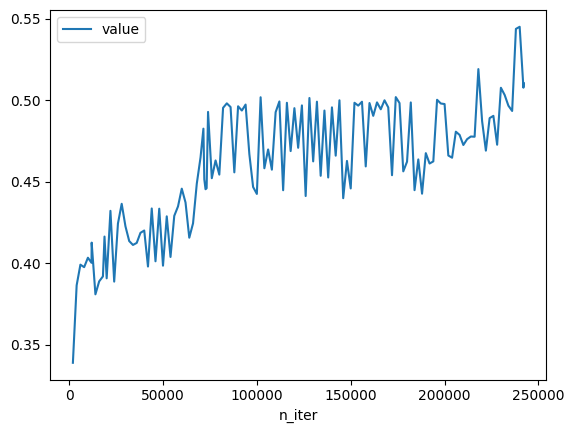

In [391]:
df_mean = df.loc[:, ["model_path", "n_iter", "value"]].groupby(["model_path", "n_iter"]).mean().reset_index()
df_mean = df_mean.sort_values(by=["model_path", "n_iter"])
ax = df_mean.loc[:, ["n_iter", "value"]].groupby("n_iter").mean().plot()

## Hyperparameter analysis

In [392]:
hp_cols = [
 'size',
 'data',
 'tokenizer',
 'n_tokens',
 'global_bs',
 'context',
 'schedule',
 'lr',
 'warmup']

In [393]:
df.drop_duplicates(hp_cols).loc[:, hp_cols].sort_values(by=["size", "data"]).reset_index(drop=True)

,size,data,tokenizer,n_tokens,global_bs,context,schedule,lr,warmup
0,0.13,DCLM,GPT-NeoX-2,300,1008,4096,WSD_lr,0.006,25000
1,0.13,DCLM,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
2,0.13,FineWeb-Edu-1.4T,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
3,0.13,HPLT-2.0,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
4,0.13,Pile,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
5,0.13,SlimPajama,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
6,0.13,c4,GPT-NeoX,300,1024,4096,WSD_lr,0.004,25000
7,0.13,c4,GPT-NeoX-2,300,1008,4096,WSD_lr,0.006,25000
8,0.40,DCLM,GPT-NeoX-2,300,1000,4096,WSD_lr,0.004,25000
9,1.70,C4,GPT-NeoX,50,2048,2048,WSD_lr,0.005,1500


In [394]:
df.loc[:, hp_cols].groupby(hp_cols).count()

Empty DataFrame
Columns: []
Index: [(0.13, DCLM, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, DCLM, GPT-NeoX-2, 300, 1008, 4096, WSD_lr, 0.006, 25000), (0.13, FineWeb-Edu-1.4T, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, HPLT-2.0, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, Pile, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, SlimPajama, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, c4, GPT-NeoX, 300, 1024, 4096, WSD_lr, 0.004, 25000), (0.13, c4, GPT-NeoX-2, 300, 1008, 4096, WSD_lr, 0.006, 25000), (0.4, DCLM, GPT-NeoX-2, 300, 1000, 4096, WSD_lr, 0.004, 25000), (1.7, C4, GPT-NeoX, 50, 1296, 2048, WSD_lr, 0.002, 10000), (1.7, C4, GPT-NeoX, 50, 1296, 2048, WSD_lr, 0.003, 10000), (1.7, C4, GPT-NeoX, 50, 1296, 2048, WSD_lr, 0.004, 10000), (1.7, C4, GPT-NeoX, 50, 2048, 2048, WSD_lr, 0.004, 1000), (1.7, C4, GPT-NeoX, 50, 2048, 2048, WSD_lr, 0.005, 1500), (1.7, C4, GPT-NeoX, 50, 2048, 2048, WSD_lr, 0.005, 2000), (1.7, C4, GPT-NeoX, 50, 2048, 2048, WSD_lr, 0.006, 2000), (1.7, C4, GPT-NeoX, 50, 2048, 2048, cosine_lr, 0.005, 1500), (1.7, C4, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 10000), (1.7, C4, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 20000), (1.7, C4, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, C4, GPT-NeoX, 300, 2048, 2048, WSD_lr, 0.004, 20000), (1.7, C4, GPT-NeoX, 300, 2048, 2048, WSD_lr, 0.004, 25000), (1.7, C4, GPT-NeoX, 300, 2048, 2048, WSD_lr, 0.004, 30000), (1.7, C4, GPT-NeoX, 300, 2048, 2048, WSD_lr, 0.005, 30000), (1.7, CommonCorpus, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, DCLM, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, DCLM, GPT-NeoX, 1000, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, FineWeb-Edu-1.4T, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, FineWeb-Edu-1.4T, GPT-NeoX, 1000, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, HPLT-2.0, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, Pile, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, SlimPajama, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000)]

## Plot for different datasets

In [395]:
config = {
    "size": 1.7,
    "tokenizer": "GPT-NeoX",
    "n_tokens": 300,
    "global_bs": 1008,
    "context": 4096,
    "schedule": "WSD_lr",
    "warmup": 25000,
}
mask = None
for key, value in config.items():
    if mask is None:
        mask = (df.loc[:, key] == value)
    else:
        mask &= (df.loc[:, key] == value)
df_model[mask].loc[:, hp_cols].groupby(hp_cols).count()

Empty DataFrame
Columns: []
Index: [(1.7, C4, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, CommonCorpus, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, DCLM, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, FineWeb-Edu-1.4T, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, HPLT-2.0, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, Pile, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, SlimPajama, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000)]

In [396]:
df.pivot_table(index="model_name", columns="benchmark", values="value").head()

benchmark,arc_challenge,arc_easy,boolq,commonsense_qa,copa,hellaswag,lambada_openai,mmlu,mmlu_pro,openbookqa,piqa,social_iqa,winogrande
model_name,,,,,,,,,,,,,
open-sci-ref_model-0.13b_data-DCLM_tokenizer-GPT-NeoX-2_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-6e-3_warmup-25000_machine-LEONARDO_14333754,0.218084,0.476101,0.549748,0.205104,0.670000,0.335251,0.380917,0.255760,0.059348,0.168541,0.641090,0.377383,0.506901
open-sci-ref_model-0.13b_data-DCLM_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14333760,0.223780,0.488238,0.531986,0.206720,0.664865,0.340365,0.388181,0.258121,0.059999,0.175730,0.642296,0.382376,0.506666
open-sci-ref_model-0.13b_data-FineWeb-Edu-1.4T_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14497641,0.248386,0.549879,0.551608,0.206919,0.624595,0.347317,0.292561,0.253622,0.059469,0.198270,0.636120,0.376885,0.510122
open-sci-ref_model-0.13b_data-HPLT-2.0_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14497644,0.208698,0.441385,0.569221,0.211833,0.655135,0.337399,0.350166,0.257476,0.064555,0.168649,0.657236,0.380356,0.510804
open-sci-ref_model-0.13b_data-Pile_tokenizer-GPT-NeoX_samples-300B_global_bs-1008_context-4096_schedule-WSD_lr-4e-3_warmup-25000_machine-LEONARDO_14497650,0.194977,0.425676,0.511034,0.204750,0.639189,0.306168,0.363299,0.245770,0.061653,0.155081,0.613181,0.367977,0.509525


/var/folders/bv/hw2pz0w124z6wd8xbw6rx8n00000gp/T/ipykernel_97910/476193574.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub["tokens"] = df["n_iter"] * df["global_bs"]


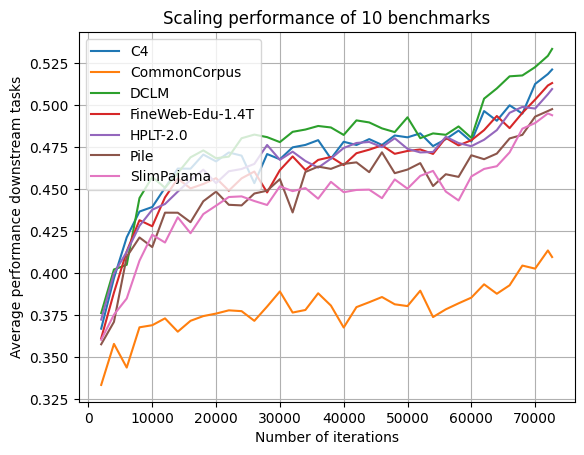

In [397]:
# compute average per iterationdf_sub.loc[:, ["size", "benchmark", "value"]] ".groupby("n_iter").mean()
df_sub = df.loc[mask]
df_sub["tokens"] = df["n_iter"] * df["global_bs"]
df_iter = df_sub.pivot_table(index=["data", "n_iter"], columns="benchmark", values="value").loc[:, bench_sel].mean(axis=1)
ax = df_iter.reset_index().pivot_table(index="n_iter", columns="data", values=0).plot()
ax.grid()
ax.set_title(f"Scaling performance of {len(bench_sel)} benchmarks");
ax.set_xlabel("Number of iterations");
ax.set_ylabel("Average performance downstream tasks");
ax.legend(
    #loc="lower center",
    loc="upper left",
    ncols=1,
)

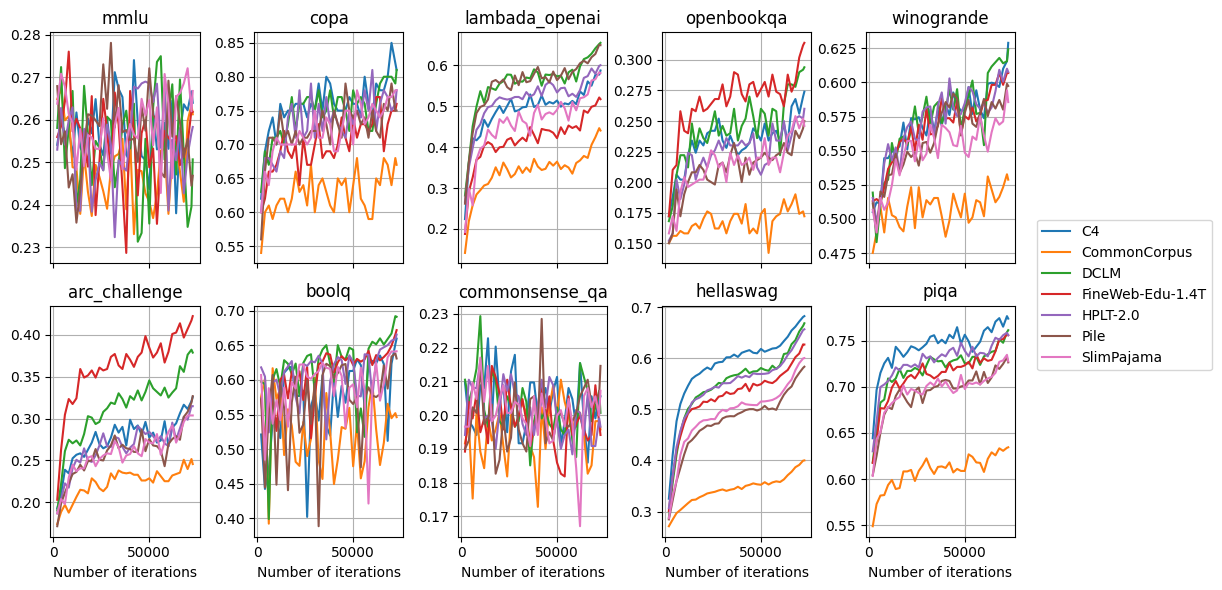

In [398]:
import numpy as np
fig, axes = plt.subplots(2, 5, figsize=(12, 6), sharex=True, sharey=False)

axes = np.ravel(axes)
lines = []  # Store line objects for legend
labels = []  # Store labels for legend

for i, benchmark in enumerate(bench_sel):
    ax = axes[i]
    # Create an explicit copy of the filtered DataFrame
    df_sub = df.loc[(mask) & (df.benchmark == benchmark)].copy()
    # Now modify the copy
    df_sub["tokens"] = df_sub["n_iter"] * df_sub["global_bs"]
    
    df_iter = df_sub.pivot_table(index=["data", "n_iter"], columns="benchmark", values="value").loc[:, benchmark]
    
    # Capture the line objects and data column names
    plot_result = df_iter.reset_index().pivot_table(index="n_iter", columns="data", values=benchmark).plot(
        ax=ax, legend=False
    )
    
    # Store the lines and labels from the first plot
    if i == 0:
        lines = plot_result.get_lines()
        labels = df_iter.reset_index().pivot_table(index="n_iter", columns="data", values=benchmark).columns.tolist()
    
    ax.grid()
    ax.set_title(f"{benchmark}")
    ax.set_xlabel("Number of iterations")

# Create a single legend outside the plot
fig.legend(lines, labels, loc='center right', bbox_to_anchor=(1.02, 0.5))

# Adjust layout to make room for the legend
plt.tight_layout()
plt.subplots_adjust(right=0.85)

## Plot for different scales

In [315]:
df.loc[df.data == "DCLM", hp_cols].groupby(hp_cols).count()

Empty DataFrame
Columns: []
Index: [(0.13, DCLM, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (0.13, DCLM, GPT-NeoX-2, 300, 1008, 4096, WSD_lr, 0.006, 25000), (0.4, DCLM, GPT-NeoX-2, 300, 1000, 4096, WSD_lr, 0.004, 25000), (1.7, DCLM, GPT-NeoX, 300, 1008, 4096, WSD_lr, 0.004, 25000), (1.7, DCLM, GPT-NeoX, 1000, 1008, 4096, WSD_lr, 0.004, 25000)]

In [231]:
config = {    
    "data": "DCLM",
    #"tokenizer": "GPT-NeoX",
    "lr": .004,
    "n_tokens": 300,
}
mask_scaling = None
for key, value in config.items():
    if mask_scaling is None:
        mask_scaling = (df.loc[:, key] == value)
    else:
        mask_scaling &= (df.loc[:, key] == value)
df[mask_scaling].loc[:, hp_cols].groupby(hp_cols).count()

,,,,,,,,
size,data,tokenizer,n_tokens,global_bs,context,schedule,lr,warmup
0.13,DCLM,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000
0.40,DCLM,GPT-NeoX-2,300,1000,4096,WSD_lr,0.004,25000
1.70,DCLM,GPT-NeoX,300,1008,4096,WSD_lr,0.004,25000


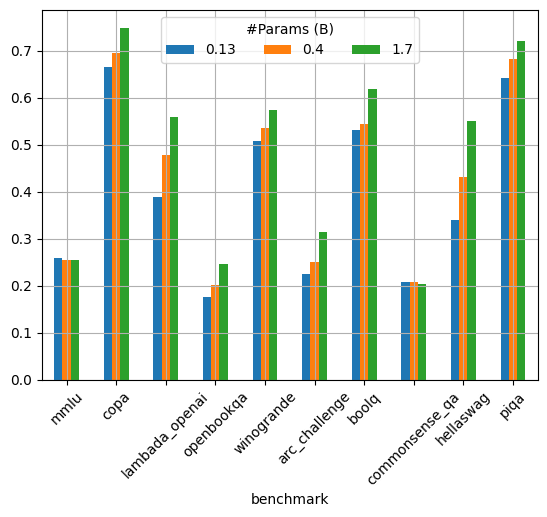

In [292]:
ax = df[mask_scaling].pivot_table(
    index="size", columns="benchmark", values="value"
).loc[:, bench_sel].T.plot(kind="bar")
ax.legend(title="#Params (B)", ncol=3)
ax.grid()
plt.xticks(rotation=45);

In [312]:
df_bench_baselines = df_baselines[df_baselines["model_path"] != "EleutherAI/pythia-160m"].pivot_table(
    index="model_path",
    columns="benchmark", 
    values="value"
).loc[:, bench_sel]


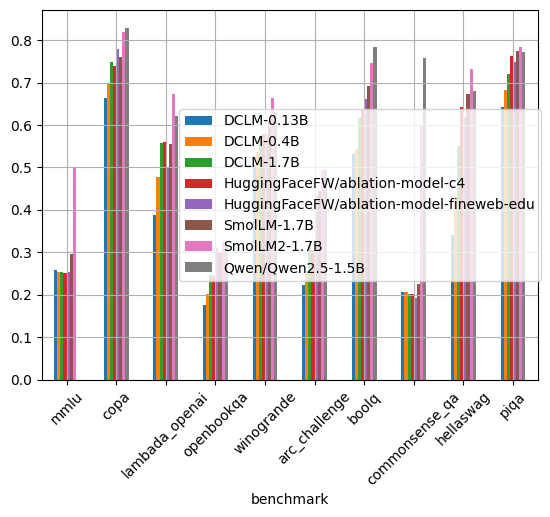

In [357]:
df_scaling = df[mask_scaling].pivot_table(
    index="size", columns="benchmark", values="value"
).loc[:, bench_sel]
df_scaling.index = [f"DCLM-{x}B" for x in df_scaling.index]

mask_baselines = (df_baselines["model_path"] != "EleutherAI/pythia-160m")# & ~(df_baselines["model_path"].str.contains("HuggingFaceFW"))
df_bench_baselines = df_baselines[mask_baselines].pivot_table(
    index="model_path",
    columns="benchmark", 
    values="value"
).loc[:, bench_sel]

df_bench_baselines.index = [x.replace("HuggingFaceTB/", "") for x in df_bench_baselines.index]

df_both = pd.concat([df_scaling, df_bench_baselines])

ax = df_both.T.plot(kind="bar")
#ax.legend(ncol=1, loc="bottom")
ax.legend(ncol=1, loc='center right', bbox_to_anchor=(1.02, 0.5))

ax.grid()
plt.xticks(rotation=45);

In [358]:
df_both

benchmark,mmlu,copa,lambada_openai,openbookqa,winogrande,arc_challenge,boolq,commonsense_qa,hellaswag,piqa
DCLM-0.13B,0.258121,0.664865,0.388181,0.175730,0.506666,0.223780,0.531986,0.206720,0.340365,0.642296
DCLM-0.4B,0.254087,0.695789,0.477637,0.202105,0.535579,0.251168,0.544536,0.206992,0.430932,0.683122
DCLM-1.7B,0.254283,0.749189,0.558169,0.245568,0.573626,0.314108,0.617704,0.202603,0.551045,0.720525
HuggingFaceFW/ablation-model-c4,0.250677,0.740000,0.560935,0.244000,0.579815,0.304608,0.634709,0.201474,0.643647,0.762242
HuggingFaceFW/ablation-model-fineweb-edu,0.252599,0.780000,0.501844,0.310000,0.579321,0.436007,0.660856,0.191646,0.619299,0.748096
SmolLM-1.7B,0.297037,0.760000,0.555793,0.300000,0.609313,0.444539,0.691437,0.225225,0.673073,0.774211
SmolLM2-1.7B,0.499929,0.820000,0.674364,0.324000,0.662983,0.494027,0.747401,0.601147,0.731627,0.783460
Qwen/Qwen2.5-1.5B,NaN,0.830000,0.620803,0.318000,0.631413,0.494027,0.783180,0.757576,0.680243,0.772035


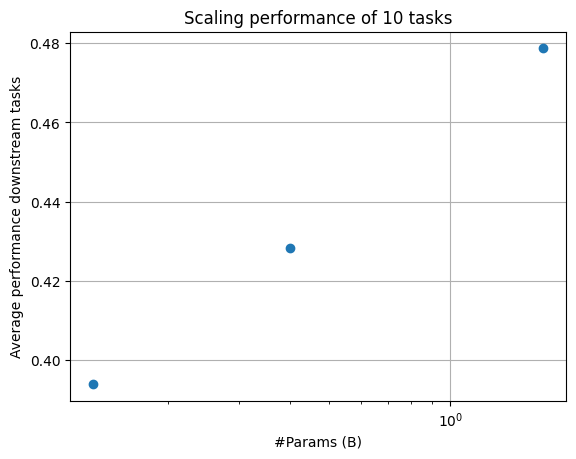

In [258]:
# TODO pull results of baselines Smolm2, etc
ax = df[mask_scaling].pivot_table(
    index="size", columns="benchmark", values="value"
).loc[:, bench_sel].mean(axis=1).plot(marker="o", linestyle="")
ax.grid()
ax.set_xscale("log")
ax.set_xlabel("#Params (B)")
ax.set_ylabel("Average performance downstream tasks")
ax.set_title(
    f"Scaling performance of {len(bench_sel)} tasks"
);
